In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd drive/My Drive/Medical_LV_Identification

/content/drive/My Drive/Medical_LV_Identification


In [0]:
pip install dicom

     |████████████████████████████████| 768kB 4.7MB/s 


Importing required packages

In [0]:
import pickle
import utils
import matplotlib.pyplot as plt 
import numpy as np
import imp
import cv2
%matplotlib inline
import pandas as pd
import json
import glob
import dicom
from matplotlib.path import Path

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.losses import mean_squared_error

from utils import *

import glob
import matplotlib.patches as patches
from sklearn.utils import shuffle

from keras.layers import Input,Dense, Dropout, Activation, Flatten, Reshape, Conv2D, MaxPooling2D, AveragePooling2D
from keras import regularizers
from keras.losses import mean_squared_error
from keras import losses


/usr/local/lib/python3.6/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
Using TensorFlow backend.


Util Functions for CNN training

In [0]:
def get_roi(image, contour, shape_out = 32):
    """
    Create a binary mask with ROI from contour. 
    Extract the maximum square around the contour.
    :param image: input image (needed for shape only)
    :param contour: numpy array contour (d, 2)
    :return: numpy array mask ROI (shape_out, shape_out)
    """
    X_min, Y_min = contour[:,0].min(), contour[:,1].min()
    X_max, Y_max = contour[:,0].max(), contour[:,1].max()  
    w = X_max - X_min
    h = Y_max - Y_min
    mask_roi = np.zeros(image.shape)
    if w > h :
        mask_roi[int(Y_min - (w -h)/2):int(Y_max + (w -h)/2), int(X_min):int(X_max)] = 1.0
    else :
        mask_roi[int(Y_min):int(Y_max), int(X_min - (h-w)/2):int(X_max + (h -w)/2)] = 1.0
    return cv2.resize(mask_roi, (shape_out, shape_out), interpolation = cv2.INTER_NEAREST)

In [0]:

def create_datasetx(image_shape=64, n_set='train', original_image_shape=256, 
                   roi_shape=32, data_path='./Data/'):
    """
    Creating the dataset from the images and the contour for the CNN.
    :param image_shape: image dataset desired size
    :param original_image_shape: original image size
    :param roi_shape: binary ROI mask shape
    :param data_path: path for the dataset
    :return: correct size image dataset, full size image dataset, label (contours) dataset
    """
    
    if n_set == 'train':
        number_set = 3
        name_set = 'Training'
    elif n_set == 'test':
        number_set = 3
        name_set = 'Training'         
    # Create dataset
    #series = json.load(open('series_case.json'))[n_set]
    # Extra code start
    InputData= {"train":
        {
         "SC-HF-NI-3" : "0379",
         "SC-HF-I-40" : "0134",
         "SC-HF-I-2" : "0106",
         "SC-HF-I-1" : "0004",
         "SC-N-3" : "0915",
         "SC-HYP-38" : "0734",
         "SC-HF-I-11" :"0043",
         "SC-HF-I-12" :"0062",
         "SC-HF-I-4" : "0116",
         
         "SC-N-9" :"1031",
          "SC-N-10" :"0851",
          "SC-N-11" :"0878",
          "SC-HYP-9" : "0003",
          "SC-HYP-10" : "0579",
          "SC-HYP-11" : "0601",
          "SC-HYP-12" : "0629",
          "SC-HF-NI-12" :"0286",
           "SC-HF-NI-13" :"0304",
           "SC-HF-NI-14" :"0331",
           "SC-HF-NI-15" :"0359",
           "SC-HF-I-9" :"0241",
           "SC-HF-I-10" :"0024"},
                
                
        "test":
        {"SC-N-40" : "0944",
         "SC-N-2" : "0898",
         "SC-HYP-40" : "0755",
         "SC-HYP-3" : "0650",
         "SC-HYP-1" : "0550",
         "SC-HF-NI-36" : "0474",
         "SC-HF-NI-34" : "0446",
         "SC-HF-NI-4" : "0501"
        }
      }
    series=InputData[n_set]    
    
    # Extra code end
    images, images_fullsize, contours, contour_mask = [], [], [], []
    # Loop over the series
    for case, serie in series.items():
        image_path_base = data_path + 'challenge_%s/%s/IM-%s' % (name_set.lower(),case, serie)
        contour_path_base = data_path + 'Sunnybrook Cardiac MR Database ContoursPart%s/\
%sDataContours/%s/contours-manual/IRCCI-expert/' % (number_set, name_set, case)
        contours_list = glob.glob(contour_path_base + '*')
        contours_list_series = [k.split('/')[7].split('-')[2] for k in contours_list]
        #contours_list_series = [k.split('\\')[1].split('-')[2] for k in contours_list]
        # Loop over the contours/images
        for c in contours_list_series:
            # Get contours and images path
            idx_contour = contours_list_series.index(c)
            image_path = image_path_base + '-%s.dcm' % c
            contour_path = contours_list[idx_contour]

            # open image as numpy array and resize to (image_shape, image_shape)
            image_part = dicom.read_file(image_path).pixel_array  

            # open contours as numpy array
            contour = []
            file = open(contour_path, 'r') 
            for line in file: 
                contour.append(tuple(map(float, line.split())))
            contour = np.array(contour)
            # append binary ROI mask 
            contours.append(get_roi(image_part, contour))

            # create mask contour with experts contours
            x, y = np.meshgrid(np.arange(256), np.arange(256)) # make a canvas with coordinates
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T 
            p = Path(contour) # make a polygon
            grid = p.contains_points(points)
            mask_contour = grid.reshape(256,256)
            mask_contour=mask_contour*1
            contour_mask.append(mask_contour)
            
            # Open image and resize it 
            images.append(cv2.resize(image_part, (image_shape, image_shape)))
            images_fullsize.append(cv2.resize(image_part, (original_image_shape, original_image_shape)))
    X_fullsize = np.array(images_fullsize)
    X = np.reshape(np.array(images), [len(images), image_shape, image_shape, 1])
    Y = np.reshape(np.array(contours), [len(contours), 1, roi_shape, roi_shape])
    print('Dataset shape :', X.shape, Y.shape)
    return X, X_fullsize, Y, contour_mask

def create_model(activation, input_shape=(64, 64)):
    """
    Simple convnet model : one convolution, one average pooling and one fully connected layer
    :param activation: None if nothing passed, e.g : ReLu, tanh, etc.
    :return: Keras model
    """
    model = Sequential()
    model.add(Conv2D(100, (11,11), activation=activation, padding='valid', strides=(1, 1), input_shape=(input_shape[0], input_shape[1], 1)))
    model.add(AveragePooling2D((6,6)))
    model.add(Reshape([-1, 8100]))
    model.add(Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Reshape([-1, 32, 32]))
    return model

def create_model_maxpooling(activation, input_shape=(64, 64)):
    """
    Simple convnet model with max pooling: one convolution, one max pooling and one fully connected layer
    :param activation: None if nothing passed, e.g : ReLu, tanh, etc.
    :return: Keras model
    """
    model = Sequential()
    model.add(Conv2D(100, (11,11), activation=activation, padding='valid', strides=(1, 1), input_shape=(input_shape[0], input_shape[1], 1)))
    model.add(MaxPooling2D((6,6)))
    model.add(Reshape([-1, 8100]))
    model.add(Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Reshape([-1, 32, 32]))
    return model

def create_model_larger(activation, input_shape=(64, 64)):
    """
    Larger (more filters) convnet model : one convolution, one average pooling and one fully connected layer:
    :param activation: None if nothing passed, e.g : ReLu, tanh, etc. 
    :return: Keras model
    """
    model = Sequential()
    model.add(Conv2D(200, (11,11), activation=activation, padding='valid', strides=(1, 1), input_shape=(input_shape[0], input_shape[1], 1)))
    model.add(AveragePooling2D((6,6)))
    model.add(Reshape([-1, 16200]))
    model.add(Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Reshape([-1, 32, 32]))
    return model

def create_model_deeper(activation, input_shape=(64, 64)):
    """
    Deeper convnet model : two convolutions, two average pooling and one fully connected layer:
    :param activation: None if nothing passed, e.g : ReLu, tanh, etc.
    :return: Keras model
    """
    model = Sequential()
    model.add(Conv2D(64, (11,11), activation=activation, padding='valid', strides=(1, 1), input_shape=(input_shape[0], input_shape[1], 1)))
    model.add(AveragePooling2D((2,2)))
    model.add(Conv2D(128, (10, 10), activation=activation, padding='valid', strides=(1, 1)))
    model.add(AveragePooling2D((2,2)))
    model.add(Reshape([-1, 128*9*9]))
    model.add(Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Reshape([-1, 32, 32]))
    return model

def create_model_full(activation, input_shape=(64, 64)):
    model = Sequential()
    model.add(Conv2D(64, (11,11), activation=activation, padding='valid', strides=(1, 1), input_shape=(input_shape[0], input_shape[1], 1)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(128, (10, 10), activation=activation, padding='valid', strides=(1, 1)))
    model.add(MaxPooling2D((2,2)))
    model.add(Reshape([-1, 128*9*9]))
    model.add(Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Reshape([-1, 32, 32]))
    return model

def training(m, X, Y, verbose, batch_size=16, epochs=50, data_augm=False):
    """
    Training CNN with the possibility to use data augmentation
    :param m: Keras model
    :param epochs: number of epochs
    :param X: training pictures
    :param Y: training binary ROI mask
    :return: history
    """
    if data_augm:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=50,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False) 
        print("br2------------------")
        datagen.fit(X)
        print("br3------------------")
        history = m.fit_generator(datagen.flow(X, Y,
                                    batch_size=batch_size),
                                    steps_per_epoch=X.shape[0] // batch_size,
                                    epochs=epochs,
                                    verbose=verbose)  
        print("br4------------------")       
    else:
        print("br5------------------")
        history = m.fit(X, Y, batch_size=batch_size, epochs=epochs, verbose=verbose)
        print("br6------------------")
    return history, m

def run(model='simple', X_to_pred=None, history=False, verbose=0, activation=None, epochs=20, data_augm=False):
    """
    Full pipeline for CNN: load the dataset, train the model and predict ROIs
    :param model: choice between different models e.g simple, larger, deeper, maxpooling
    :param activation: None if nothing passed, e.g : ReLu, tanh, etc.
    :param epochs: number of epochs
    :param X_to_pred: input for predictions after training (X_train if not specified)
    :param verbose: int for verbose
    :return: X, X_fullsize, Y, y_pred, h (if history boolean passed)
    """
    X, X_fullsize, Y, contour_mask = create_datasetx()
    if model == 'simple':
        m = create_model(activation=activation)
    elif model == 'larger':
        m = create_model_larger(activation=activation)
    elif model == 'deeper':
        m = create_model_deeper(activation=activation)
    elif model == 'maxpooling':
        m = create_model_maxpooling(activation=activation)
    elif model =='full':
        m = create_model_full(activation=activation)

    m.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])
    if verbose > 0:
        print('Size for each layer :\nLayer, Input Size, Output Size')
        for p in m.layers:
            print(p.name.title(), p.input_shape, p.output_shape)
    print("---------br1")
    h, m = training(m, X, Y, verbose=verbose, batch_size=16, epochs=epochs, data_augm=data_augm)

    if not X_to_pred:
        X_to_pred = X
    y_pred = m.predict(X_to_pred, batch_size=16)
    
    if history:
        return X, X_fullsize, Y, contour_mask, y_pred, h, m
    else:
        return X, X_fullsize, Y, contour_mask, y_pred, m

def inference(model):
    X_test, X_fullsize_test, Y_test, contour_mask_test = create_datasetx(n_set='test')
    y_pred = model.predict(X_test, batch_size=16)
    return X_test, X_fullsize_test, Y_test, contour_mask_test, y_pred


Training CNN:

In [0]:
variants = ['simple', 'larger', 'deeper', 'maxpooling']
models_cnn = {k:run(model=k, history=True) for k in variants}

Dataset shape : (66, 64, 64, 1) (66, 1, 32, 32)
Instructions for updating:
Colocations handled automatically by placer.
---------br1
br5------------------
Instructions for updating:
Use tf.cast instead.
br6------------------
Dataset shape : (66, 64, 64, 1) (66, 1, 32, 32)
---------br1
br5------------------
br6------------------
Dataset shape : (66, 64, 64, 1) (66, 1, 32, 32)
---------br1
br5------------------
br6------------------
Dataset shape : (66, 64, 64, 1) (66, 1, 32, 32)
---------br1
br5------------------
br6------------------


In [0]:
models_cnn['relu'] = run(model='simple', history=True, activation='relu')

Dataset shape : (66, 64, 64, 1) (66, 1, 32, 32)
---------br1
br5------------------
br6------------------


Plotting All models:

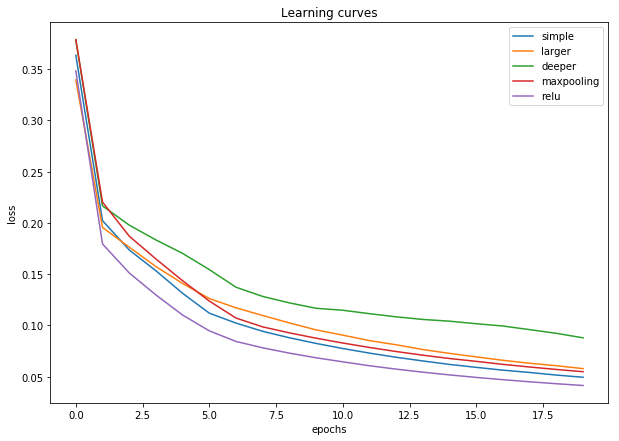

In [0]:
plt.figure(figsize=(10,7))
for k, v in models_cnn.items():
    it = range(len(v[5].history['loss']))
    plt.plot(it, v[5].history['loss'], label=k)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title("Learning curves")
plt.legend()

Predicting on CNN Model:

In [0]:
a = {k:inference(v[6]) for k,v in models_cnn.items()}

Dataset shape : (91, 64, 64, 1) (91, 1, 32, 32)
Dataset shape : (91, 64, 64, 1) (91, 1, 32, 32)
Dataset shape : (91, 64, 64, 1) (91, 1, 32, 32)
Dataset shape : (91, 64, 64, 1) (91, 1, 32, 32)
Dataset shape : (91, 64, 64, 1) (91, 1, 32, 32)


**Util functions for stacked ae**

In [0]:
def open_data_AE(X_fullsize, y_pred, contour_mask):
    """
    Open dataset from the output of the CNN and
    unroll it as 64*64 = vector of 4096 elements
    :param X_fullsize: full size training set (256x256)
    :param y_pred: CNN output
    :return: input AE, output
    """
    input_AE = []
    contour_experts = []
    for j in range(y_pred.shape[0]):
        in_AE = cv2.resize(compute_roi_pred(X_fullsize, y_pred, contour_mask, j, roi_shape=32)[0],(64 , 64))
        contour = cv2.resize(compute_roi_pred(X_fullsize, y_pred, contour_mask, j)[2], (64,64), interpolation = cv2.INTERSECT_NONE)
        input_AE.append(in_AE)
        contour_experts.append(contour)
    return np.array(input_AE).reshape((-1, 64*64)), np.array(contour_experts).reshape((-1, 64*64))

def customized_loss(y_true, y_pred, alpha=0.0001, beta=3):
    """
    Create a customized loss for the stacked AE.
    Linear combination of MSE and KL divergence.
    """
    #customize your own loss components
    loss1 = losses.mean_absolute_error(y_true, y_pred)
    loss2 = losses.kullback_leibler_divergence(y_true, y_pred)
    #adjust the weight between loss components
    return (alpha/2) * loss1 + beta * loss2

def model1(X_train, param_reg, get_history=False, verbose=0,loss = "customized_loss"):
    """
    First part of the stacked AE.
    Train the AE on the ROI input images.
    :param X_train: ROI input image
    :param get_history: boolean to return the loss history
    :param loss: if "customized_loss" -> customized_loss
    :return: encoded ROI image
    """
    autoencoder_0 = Sequential()
    encoder_0 = Dense(input_dim=4096, units=100, kernel_regularizer=regularizers.l2(param_reg))
    decoder_0 = Dense(input_dim=100, units=4096, kernel_regularizer=regularizers.l2(param_reg))
    autoencoder_0.add(encoder_0)
    autoencoder_0.add(decoder_0)
    if (loss == "customized_loss"):
        loss = customized_loss
    autoencoder_0.compile(loss = loss,optimizer='adam', metrics=['accuracy'])
    h = autoencoder_0.fit(X_train, X_train, epochs=100, verbose=verbose)

    temp_0 = Sequential()
    temp_0.add(encoder_0)
    temp_0.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
    encoded_X = temp_0.predict(X_train, verbose=0)
    if get_history:
        return h.history['loss'], encoded_X, encoder_0
    else:
        return encoded_X, encoder_0

def model2(encoder_0, encoded_X, X_train, param_reg, get_history=False, verbose=0,loss = "customized_loss"):
    """
    Second part of the stacked AE.
    :param X_train: encoder ROI image
    :param get_history: boolean to return the loss history
    :return: encoding layer
    """
    autoencoder_1 = Sequential()
    encoder_1 = Dense(input_dim=100, units=100, kernel_regularizer=regularizers.l2(param_reg))
    decoder_1 = Dense(input_dim=100, units=100, kernel_regularizer=regularizers.l2(param_reg))
    autoencoder_1.add(encoder_1)
    autoencoder_1.add(decoder_1)
    if (loss == "customized_loss"):
        loss = customized_loss
    autoencoder_1.compile(loss= loss, optimizer='adam', metrics=['accuracy'])
    h = autoencoder_1.fit(encoded_X, encoded_X, epochs=100, verbose=verbose)

    temp_0 = Sequential()
    temp_0.add(encoder_0)
    temp_0.compile(loss= loss, optimizer='adam', metrics=['accuracy'])
    encoded_X = temp_0.predict(X_train, verbose=0)
    if get_history:
        return h.history['loss'], encoder_1
    else:
        return encoder_1

def model3(X_train, Y_train, encoder_0, encoder_1, init, param_reg,
           get_history=False, verbose=0,loss = "MSE"):
    """
    Last part of the stacked AE.
    :param X_train: ROI input image
    :param init: set the initial kernel weights (None for uniform)
    :param get_history: boolean to return the loss history
    :return: final model
    """
    model = Sequential()
    model.add(encoder_0)
    model.add(encoder_1)
    model.add(Dense(input_dim=100, units=4096, kernel_initializer=init, kernel_regularizer=regularizers.l2(param_reg)))
    if (loss == "customized_loss"):
        loss = customized_loss
    model.compile(optimizer = 'adam', loss = loss, metrics=['accuracy'])
    h = model.fit(X_train, Y_train, epochs=20, verbose=verbose)
    if get_history:
        return h.history['loss'], model
    else:
        return model

def runAE(X_fullsize, y_pred, contour_mask, X_to_pred=None, verbose=0, param_reg=3*0.001, init_3='zero',history=False ,loss1 = "customized_loss",loss2 = "customized_loss",loss3 = "MSE"):
    """
    Full pipeline for CNN: load the dataset, train the model and predict ROIs
    :param X_fullsize: full size training set (256x256)
    :param y_pred: CNN output for training
    :param X_to_pred: input for predictions after training (X_train if not specified)
    :param verbose: int for verbose
    :return: X_train, Y_train, contours_pred
    """
    X_train, Y_train = open_data_AE(X_fullsize, y_pred, contour_mask)
    encoded_X, encoder_0 = model1(X_train, param_reg=param_reg,loss = loss1)
    encoder_1 = model2(encoder_0, encoded_X, X_train, param_reg=param_reg,loss = loss2)
    h, model = model3(X_train, Y_train, encoder_0, encoder_1, param_reg=param_reg, 
        init=init_3, get_history=True, verbose=verbose,loss = loss3)
    if not X_to_pred:
        X_to_pred = X_train
    contours = model.predict(X_to_pred)
    binarys = np.array([cv2.threshold(contour, 0, 1, cv2.INTERSECT_NONE)[1].reshape((64,64)) for contour in contours])
    if history:
        return X_train, Y_train, binarys, model, h 
    else:
        return X_train, Y_train, binarys, model

def inferenceAE(X_fullsize, y_pred, contour_mask, model):
    X_test, Y_test = open_data_AE(X_fullsize, y_pred, contour_mask)
    contours = model.predict(X_test)
    binarys = np.array([cv2.threshold(contour, 0, 1, cv2.INTERSECT_NONE)[1].reshape((64,64)) for contour in contours])
    return X_test, Y_test, binarys

Training AE (Auto encoders.. Extended pard to CNN)

In [0]:
models_stackedae = {k:runAE(v[1], v[4], v[3]) for k,v in models_cnn.items()}

Predicting on AE Model

In [0]:
inference_sae = {k:inferenceAE(v[1], v[4], v[3], models_stackedae[k][3]) for k,v in a.items()}

In [0]:
metrics_test = {k:utils.stats_results(v[1], v[2]) for k,v in inference_sae.items()}

Plotting Test image and predictions on different models

Text(0.5, 1.0, 'Ground Truth')

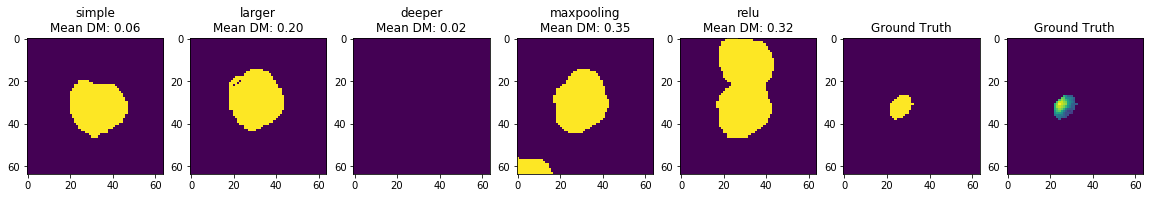

In [0]:
idx = 20
f, ax = plt.subplots(ncols=len(metrics_test)+2, figsize=(20,5))
for i, (model, v) in enumerate(inference_sae.items()):
    ax[i].imshow(v[2][idx])
    ax[i].set_title('%s\nMean DM: %.2f' % (model, metrics_test[model][0].mean()))
#     cv2.imwrite('./Rapport/images/results_%s_img%s.png' % (model,idx), v[2][idx]*255)
ax[5].imshow(v[1][idx].reshape((64,64)))
ax[5].set_title('Ground Truth')

ax[6].imshow(v[1][idx].reshape((64,64))*v[0][idx].reshape((64,64)))
ax[6].set_title('Ground Truth')

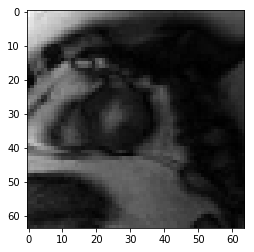

In [0]:
i = v[1][idx].reshape((64,64))*v[0][idx].reshape((64,64))
plt.imshow(v[0][idx].reshape((64,64)), cmap='gray')

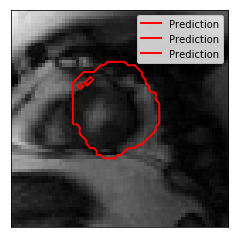

In [0]:
from skimage import measure
# Find contours at a constant value of 0.8
contours_truth = measure.find_contours(v[1][idx].reshape((64,64)), 0.8)
contours_larger = measure.find_contours(inference_sae['larger'][2][idx], 0.8)
fig, ax = plt.subplots()
ax.imshow(v[0][idx].reshape((64,64)), cmap='gray')

#for n, contour in enumerate(contours_truth):
    #ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='green', label='Ground Truth')
for n, contour in enumerate(contours_larger):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red', label='Prediction')
    
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.legend(bbox_to_anchor=(1,1))
#plt.savefig('./Rapport/images/image_with_contour_truth_pred.png')

Change numbers to get predictions for different images...i.e idx

**DONE THANKS**

Below is extra code... With some more test scenarios

In [0]:
try:
    _, X_fullsize, _, contour_mask, y_pred, h, m = models_cnn['simple']
except:
    _, X_fullsize, _, contour_mask, y_pred, h, m = train_cnn.run(model='simple', history=True)

In [0]:
inits = ['zero', 'random_uniform', 'random_normal']
models_sae_init = {k:runAE(X_fullsize, y_pred, contour_mask, init_3=k, history=True) for k in inits}

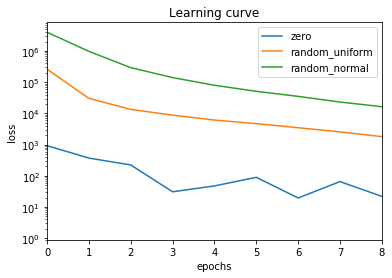

In [0]:
for k, v in models_sae_init.items():
    it = range(len(v[4]))
    plt.plot(it, v[4], label=k)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title("Learning curve")
plt.legend()
plt.xlim([0,8])
plt.yscale("log", nonposy='clip')

In [0]:
loss = ["customized_loss", "MSE", "kullback_leibler_divergence"]
models_sae_loss = {'%s + MSE' % l :runAE(X_fullsize, y_pred, contour_mask, history=True, 
                            loss1=l, loss2=l, loss3="MSE") for l in loss}

In [0]:
metrics_sae_loss = {k:utils.stats_results(v[1], v[2]) for k, v in models_sae_loss.items()}

In [0]:
for k, v in metrics_sae_loss.items():
    print('%s - DM :%.1f%%, CC :%.1f' % (k, 100*v[0].mean(), v[1].mean()))

customized_loss + MSE - DM :4.6%, CC :-90.8
MSE + MSE - DM :34.5%, CC :-33.7
kullback_leibler_divergence + MSE - DM :6.2%, CC :-38.0


Text(0.5, 1.0, 'Ground Truth')

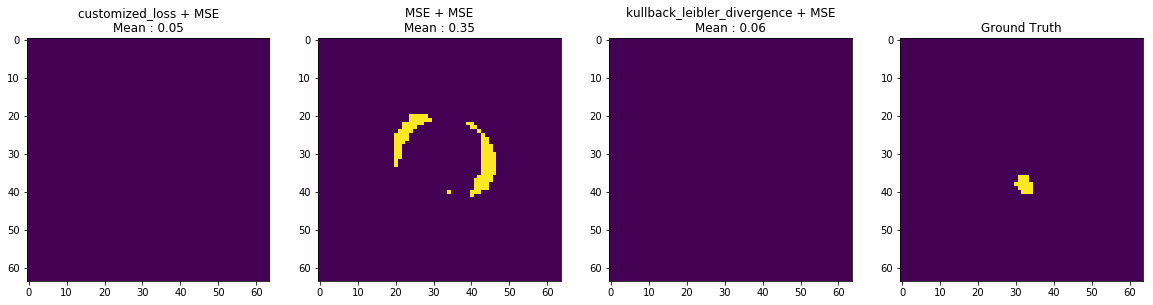

In [0]:
idx = 45
f, ax = plt.subplots(ncols=len(metrics_sae_loss)+1, figsize=(20,5))
for i, (model, v) in enumerate(models_sae_loss.items()):
    ax[i].imshow(v[2][idx])
    ax[i].set_title('%s\nMean : %.2f' % (model, metrics_sae_loss[model][0].mean()))
ax[3].imshow(v[1][idx].reshape((64,64)))
ax[3].set_title('Ground Truth')

In [0]:
X_test, X_fullsize_test, Y_test, contour_mask_test, y_pred = inference(models_cnn['simple'][6])

Dataset shape : (91, 64, 64, 1) (91, 1, 32, 32)


In [0]:

inference_sae_loss = {k:inferenceAE(X_fullsize_test, y_pred, contour_mask_test, v[3]) 
                          for k,v in models_sae_loss.items()}
metrics_sae_loss_inf = {k:utils.stats_results(v[1], v[2]) for k, v in inference_sae_loss.items()}
print('model - DM: Test (Train), CC: Test (Train)')
for (k, v), (k1,v1) in zip(metrics_sae_loss_inf.items(),metrics_sae_loss.items()):
    print('%s - DM: %.1f%% (%.1f%%), CC: %.1f (%.1f)' % (k, 100*v[0].mean(), 100*v1[0].mean(), 
                                                     v[1].mean(), v1[1].mean()))

model - DM: Test (Train), CC: Test (Train)
customized_loss + MSE - DM: 3.2% (4.6%), CC: -3.6 (-90.8)
MSE + MSE - DM: 34.2% (34.5%), CC: -17.5 (-33.7)
kullback_leibler_divergence + MSE - DM: 6.5% (6.2%), CC: -37.0 (-38.0)


Text(0.5, 1.0, 'Ground Truth')

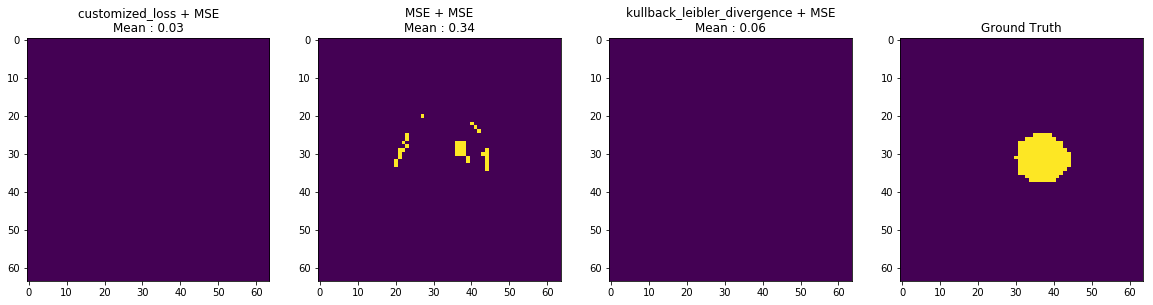

In [0]:
idx = 45
f, ax = plt.subplots(ncols=len(metrics_sae_loss_inf)+1, figsize=(20,5))
for i, (model, v) in enumerate(inference_sae_loss.items()):
    ax[i].imshow(v[2][idx])
    ax[i].set_title('%s\nMean : %.2f' % (model, metrics_sae_loss_inf[model][0].mean()))
ax[3].imshow(v[1][idx].reshape((64,64)))
ax[3].set_title('Ground Truth')

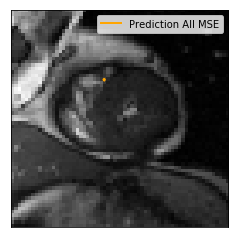

In [0]:
from skimage import measure
# Find contours at a constant value of 0.8
contours_truth = measure.find_contours(v[1][idx].reshape((64,64)), 0.8)
contours_simple = measure.find_contours(inference_sae_loss['customized_loss + MSE'][2][idx], 0.8)
contours_mse = measure.find_contours(inference_sae_loss['MSE + MSE'][2][idx], 0.8)

fig, ax = plt.subplots()
ax.imshow(v[0][idx].reshape((64,64)), cmap='gray')

#for n, contour in enumerate(contours_truth):
    #ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='green', label='Ground Truth')
for n, contour in enumerate(contours_simple[:1]):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red', label='Prediction Regular')
for n, contour in enumerate(contours_mse[:1]):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='orange', label='Prediction All MSE')
    
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.legend(bbox_to_anchor=(1,1))
#plt.savefig('./Rapport/images/image_with_contour_truth_pred_SAE.png')